In [6]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pandas as pd
import matplotlib.pyplot as plt
from Graph import *

## Test the Graph class

In [ ]:
vertex1 = Vertex(60, 2, 0)
vertex2 = Vertex(61, 3, 0)

edge = Edge([vertex1, vertex2])

print(edge.angle, edge.length, edge.intermediate_point())

In [ ]:
graph = Graph(warnings = True)

last_vertex = Vertex(-1, -1, 0, warnings = True)
graph.add_vertices(last_vertex)

for i in range(0,10):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph.add_vertices(new_vertex)
    last_vertex = new_vertex

In [ ]:
pp.pprint(graph.vertices)
pp.pprint(graph.edges)
    
for i in range(5):
    cur_vertex = next(iter(graph.vertices))
    cur_vertex.set_graph(None)

    pp.pprint(graph.vertices)
    pp.pprint(graph.edges)
    pp.pprint("")

In [39]:
print(calculate_angle(60, 61, 2, 3))
print(calculate_angle(60, 61, 3, 2))

346.10049260270813
13.89950739729187


## Angle graphifying

In [2]:
df = pd.read_csv("presets/0.csv")

In [3]:
tra = df["trajectory"][0]
dft = df[df["trajectory"] == tra]

In [71]:
max_angle_change = 45

graph = Graph()

latitude = dft.loc[0, "latitude"]
longitude = dft.loc[0, "longitude"]
altitude = dft.loc[0, "altitude"]

last_vertex = Vertex(latitude, longitude, altitude, graph)
last_latitude = dft.loc[1, "latitude"]
last_longitude = dft.loc[1, "longitude"]
last_altitude = dft.loc[1, "altitude"]

last_angle = last_vertex.angle_to_point(last_latitude, last_longitude)

for i in range(2,len(dft)):
    cur_latitude = dft.loc[i, "latitude"]
    cur_longitude = dft.loc[i, "longitude"]   
    cur_altitude = dft.loc[i, "altitude"]
    
    cur_angle = calculate_angle(last_latitude, cur_latitude, last_longitude, cur_longitude)
    
    if abs(last_angle-cur_angle) > max_angle_change:
        new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
        Edge([last_vertex, new_vertex])
        
        last_angle = cur_angle
        last_vertex = new_vertex
    
    last_latitude = cur_latitude
    last_longitude = cur_longitude
    last_altitude = cur_altitude
    
new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
Edge([last_vertex, new_vertex])

print(graph.vertices)
print(graph.edges)

{<Vertex: 40.009021,116.321625,44>, <Vertex: 40.009021,116.321625,44>, <Vertex: 40.009013,116.321659,44>, <Vertex: 40.008921,116.321484,43>, <Vertex: 40.008481,116.32244,66>, <Vertex: 40.008984,116.321525,41>, <Vertex: 40.008984,116.321525,41>, <Vertex: 40.008958,116.321457,41>, <Vertex: 40.008971,116.321436,41>, <Vertex: 40.009022,116.321434,41>, <Vertex: 40.009025,116.321374,40>, <Vertex: 40.009081,116.321486,41>, <Vertex: 40.00908,116.321479,41>, <Vertex: 40.00908,116.321479,41>, <Vertex: 40.009094,116.32152,41>, <Vertex: 40.009072,116.321585,43>, <Vertex: 40.00908,116.321442,43>, <Vertex: 40.009087,116.321453,43>, <Vertex: 40.009065,116.321479,45>, <Vertex: 40.009105,116.321616,44>, <Vertex: 40.008995,116.321407,43>, <Vertex: 40.008995,116.321407,43>, <Vertex: 40.008999,116.321412,43>, <Vertex: 40.008994,116.321389,44>, <Vertex: 40.008994,116.321389,44>, <Vertex: 40.008995,116.321392,44>, <Vertex: 40.009235,116.321472,44>, <Vertex: 40.009268,116.321446,45>, <Vertex: 40.00927,116.32

reduced from 907 to 294 points


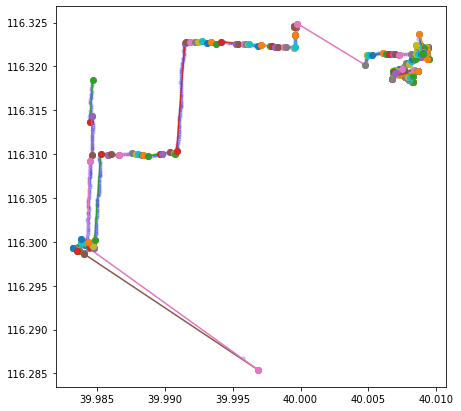

In [72]:
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

for edge in graph.edges:
    lat1 = min(edge.vertices).latitude
    long1 = min(edge.vertices).longitude
    
    lat2 = max(edge.vertices).latitude
    long2 = max(edge.vertices).longitude
    
    plt.plot([lat1, lat2], [long1, long2], marker = 'o')
    

print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

In [92]:
max_angle_change = 15

graph = Graph()

start_latitude = dft.loc[0, "latitude"]
start_longitude = dft.loc[0, "longitude"]
altitude = dft.loc[0, "altitude"]

last_vertex = Vertex(start_latitude, start_longitude, altitude, graph)
last_latitude = dft.loc[1, "latitude"]
last_longitude = dft.loc[1, "longitude"]
last_altitude = dft.loc[1, "altitude"]

last_angle = last_vertex.angle_to_point(last_latitude, last_longitude)

for i in range(2,len(dft)):
    cur_latitude = dft.loc[i, "latitude"]
    cur_longitude = dft.loc[i, "longitude"]   
    cur_altitude = dft.loc[i, "altitude"]
    
    cur_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
        
    if abs(last_angle-cur_angle) > max_angle_change:
        new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
        Edge([last_vertex, new_vertex])
        
        last_angle = cur_angle
        last_vertex = new_vertex
        
        start_altitude = last_altitude
        start_longitude = last_longitude
    
    last_latitude = cur_latitude
    last_longitude = cur_longitude
    last_altitude = cur_altitude
    
new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
Edge([last_vertex, new_vertex])

print(graph.vertices)
print(graph.edges)

{<Vertex: 39.991132,116.318231,29>, <Vertex: 39.991169,116.31848,30>, <Vertex: 39.991389,116.321583,16>, <Vertex: 39.991368,116.321736,16>, <Vertex: 39.999769,116.324886,53>, <Vertex: 40.009328,116.320887,25>, <Vertex: 39.984683,116.31845,150>, <Vertex: 39.984688,116.318385,150>, <Vertex: 39.984019,116.298663,64>, <Vertex: 39.995777,116.286798,218>, <Vertex: 39.996832,116.285446,84>, <Vertex: 39.988397,116.309931,46>, <Vertex: 39.988553,116.309866,42>, <Vertex: 39.989173,116.309866,42>, <Vertex: 39.991058,116.312473,25>}
{<Edge: (<Vertex: 39.991368,116.321736,16>) -> (<Vertex: 39.999769,116.324886,53>)>, <Edge: (<Vertex: 39.999769,116.324886,53>) -> (<Vertex: 40.009328,116.320887,25>)>, <Edge: (<Vertex: 39.984688,116.318385,150>) -> (<Vertex: 39.984683,116.31845,150>)>, <Edge: (<Vertex: 39.984019,116.298663,64>) -> (<Vertex: 39.984688,116.318385,150>)>, <Edge: (<Vertex: 39.995777,116.286798,218>) -> (<Vertex: 39.984019,116.298663,64>)>, <Edge: (<Vertex: 39.996832,116.285446,84>) -> (<V

reduced from 907 to 15 points


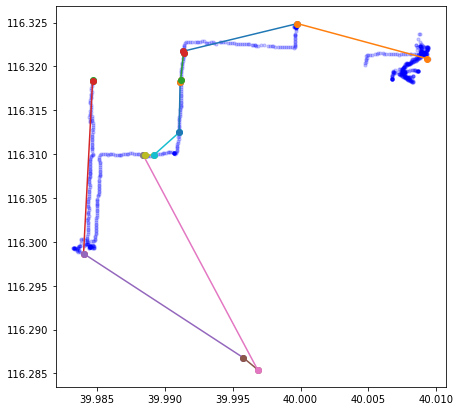

In [93]:
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

for edge in graph.edges:
    lat1 = min(edge.vertices).latitude
    long1 = min(edge.vertices).longitude
    
    lat2 = max(edge.vertices).latitude
    long2 = max(edge.vertices).longitude
    
    plt.plot([lat1, lat2], [long1, long2], marker = 'o')
    

print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

In [82]:
dft[dft["latitude"] == 39.995777]

,latitude,longitude,altitude,date,trajectory,user,transportation
147,39.995777,116.286798,218,2008-10-23 12:08:07,0.20081,0,NaN


In [85]:
dft[145:150]

,latitude,longitude,altitude,date,trajectory,user,transportation
145,39.984045,116.298725,63,2008-10-23 11:05:10,0.20081,0,NaN
146,39.984019,116.298663,64,2008-10-23 11:05:15,0.20081,0,NaN
147,39.995777,116.286798,218,2008-10-23 12:08:07,0.20081,0,NaN
148,39.996832,116.285446,84,2008-10-23 12:08:12,0.20081,0,NaN
149,39.984397,116.299292,284,2008-10-23 12:08:42,0.20081,0,NaN
